# Combiom. Statistical analysis, cross validation and plotting

Statistical analysis of results using Pandas and Scikit-Learn, cross-validation, and plotting.

# Importing modules

In [13]:
import IPython.display as ipy
import pandas as pd
import csv
import numpy as np
import itertools
import xlsxwriter
import numexpr as ne

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sc

import sklearn.linear_model as sk_lm
import sklearn.preprocessing as sk_pr
import sklearn.kernel_ridge as sk_kr
import sklearn.model_selection as sk_cv

import seaborn as sns
import string as st

### Seaborn style

In [14]:
colors = ["#332288", "#117733", "#AA4499", "#AA4499"]
sns.set(style='whitegrid', context="talk", palette=sns.color_palette(colors),
        font="Noto Sans", font_scale=1.1,
        rc={'axes.linewidth': 1.5,
            'axes.labelsize': 16,
            'axes.labelweight': 'bold',
            'axes.edgecolor': '0.25',
            'axes.grid': False,
            'font.family': 'sans-serif',
            'font.sans-serif': 'Roboto Condensed',
            'ytick.major.size': 6,
            'xtick.major.size': 6,
            'ytick.major.width': 1.5,
            'xtick.major.width': 1.5,
            'ytick.color': '0.25',
            'xtick.color': '0.25'
})

# 1 Biochemical markers

## 1.1 Importing Data

In [15]:
# read pickle to pandas DataFrame
bio_df = pd.read_pickle('biochem_db.pickle')

# biomarkers
bio_df['Biomarker'].count()

2913

## 1.2 Importing and Preprocessing Raw Data

In [16]:
# Parameter names
bio_csv_names = csv.reader(open('./BiochemData/parameters-names.csv'), delimiter=';')
bio_parameter_names = np.array(list(bio_csv_names)).flatten()

# Setting shape of data array
bio_volunteers = 10
bio_parameters = 11
bio_points = 8

# Initializing data array with zeros
bio_data = np.zeros(shape=(bio_volunteers, bio_parameters, bio_points))

# Timepoints at which each biochemical parameter was measured (in hours after experiment)
# Null stands for "before experiment", 1 - in an hour after experiment, so on...
bio_timepoints = np.array([0, 1, 1*24, 2*24, 3*24, 5*24, 7*24, 9*24])

# Reading numeric data from csv-files
# Each file has a shape of N x M
#     where N is the number of parameters and M is the number of timepoints at which they were measured
for i in np.arange(bio_volunteers):
    bio_csv_file = csv.reader(open('./BiochemData/%d.csv' % i), delimiter=';')
    bio_data[i, :, :] = np.array(list(bio_csv_file), np.float64)

In [17]:
# Target markers
bio_target_names = np.array(['Creatinekinase', 'AST', 'Myoglobin',
                    'Creatinekinase / AST', 'Creatinekinase / Myoglobin',
                    'Creatinekinase / Albumin', 'Myoglobin / Albumin'])

# Reading data for creatine kinase
bio_csv_ck = csv.reader(open('./BiochemData/creatine-kinase.csv'), delimiter=';')
bio_ckdata = np.array(list(bio_csv_ck), np.float64)

# Reading data for aspartate transferase
bio_csv_ast = csv.reader(open('./BiochemData/aspartate-transferase.csv'), delimiter=';')
bio_astdata = np.array(list(bio_csv_ast), np.float64)

# Reading data for myoglobin
bio_csv_mg = csv.reader(open('./BiochemData/myoglobin.csv'), delimiter=';')
bio_mgdata = np.array(list(bio_csv_mg), np.float64)
bio_mgdata[bio_mgdata == 0] = np.nan

imp = sk_pr.Imputer(missing_values='NaN', strategy='mean')
bio_mgdata = imp.fit_transform(bio_mgdata)

# Reading data for albumin
bio_csv_alb = csv.reader(open('./BiochemData/albumin.csv'), delimiter=';')
bio_albdata = np.array(list(bio_csv_alb), np.float64)
bio_albdata[bio_albdata == 0] = np.nan

# Processing creatinekinase and AST data
# Making an array of maximum values and taking a LOG10 element-wisely
bio_ckmax = np.log10([np.max(z) for z in bio_ckdata])
bio_astmax = np.log10([np.max(z) for z in bio_astdata])
bio_mgmax = np.log10([np.max(z) for z in bio_mgdata])

bio_alb = np.log10(bio_albdata[np.arange(bio_albdata.shape[0]), [np.argmax(z) for z in bio_ckdata]])

bio_ckmg = bio_ckmax / np.log10(bio_mgdata[np.arange(bio_mgdata.shape[0]), [np.argmax(z) for z in bio_ckdata]])
bio_ckast = bio_ckmax / np.log10(bio_astdata[np.arange(bio_astdata.shape[0]), [np.argmax(z) for z in bio_ckdata]])
bio_ckalb = bio_ckmax / bio_alb
bio_mgalb = bio_mgmax / bio_alb

bio_target_data = np.vstack((bio_ckmax, bio_astmax, bio_mgmax, bio_ckmg, bio_ckast, bio_ckalb, bio_mgalb))

# Making an array of 1-hour measures
bio_data1h = bio_data[:,:,1].T

## 1.3 Results

### 1.3.1 Markers with highest correlations

In [18]:
# process DataFrame
z = bio_df.sort_values(by='Kernel Ridge Score', ascending=False)\
          .head(10)\
          .reset_index(drop=True)\
          [['Biomarker', 'Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score', 'Type', 'MID']]

ipy.display(z)

# initialize ExcelWriter
writer = pd.ExcelWriter('Results/combinatorial_biochemical_markers_highest_corrs.xlsx', engine='xlsxwriter')

# convert the dataframe to an XlsxWriter Excel object
z.to_excel(writer, sheet_name='Markers')

workbook = writer.book
worksheet = writer.sheets['Markers']
worksheet.conditional_format('D2:D11', {'type': '2_color_scale',
                                        'min_color': '#FFFAD2',
                                        'max_color': '#ED875E'})
worksheet.conditional_format('E2:E11', {'type': '2_color_scale',
                                        'min_color': '#E6F5FE',
                                        'max_color': '#77B7E5'})
worksheet.conditional_format('F2:F11', {'type': '2_color_scale',
                                        'min_color': '#CAE0AB',
                                        'max_color': '#4EB265'})
# Save an Excel file
writer.save()

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score,Type,MID
0,TAG*Phosphate/Urea/Uric acid,Creatinekinase,0.991675,0.281999,0.852970,a*b/c/d,"4, 5, 2, 9"
1,TAG*Phosphate/Urea/Uric acid,Creatinekinase / Albumin,0.991216,0.275330,0.750298,a*b/c/d,"4, 5, 2, 9"
2,Urea*Glucose/Uric acid/MCFA,AST,0.990792,0.850640,0.847223,a*b/c/d,"2, 8, 9, 10"
3,Urea*Glucose/Uric acid/MCFA,Myoglobin / Albumin,0.988661,0.414401,1.125844,a*b/c/d,"2, 8, 9, 10"
4,TAG*Chloride/Urea/Bilirubin,Creatinekinase / AST,0.988465,0.012325,0.022768,a*b/c/d,"4, 6, 2, 7"
5,Glucose/Cholesterol/MCFA,Creatinekinase / AST,0.987554,0.777316,0.542058,a/b/c,"8, 1, 10"
6,Chloride*Glucose/Creatinine/MCFA,Creatinekinase / AST,0.987519,0.472031,0.256078,a*b/c/d,"6, 8, 0, 10"
7,Phosphate/Creatinine/Chloride,AST,0.986880,0.388254,0.883730,a/b/c,"5, 0, 6"
8,TAG/Glucose/MCFA,Creatinekinase / AST,0.986831,0.169857,0.367042,a/b/c,"4, 8, 10"
9,Cholesterol*MCFA/Chloride/Glucose,Creatinekinase / AST,0.986334,0.480622,0.366216,a*b/c/d,"1, 10, 6, 8"


### 1.3.2 Grouping markers by type

In [19]:
# Showing top 5 of each type
for i, g in enumerate(bio_df.groupby('Type').groups.keys()):
    ipy.display(ipy.Markdown('### Combinatorial biomarkers of type _' + g + '_'))
    ipy.display(bio_df.groupby('Type')\
                .get_group(g)\
                .sort_values(by='Kernel Ridge Score', ascending=False)\
                .head(5)\
                .reset_index(drop=True))

### Combinatorial biomarkers of type _a_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Uric acid,Myoglobin,Uric acid,NaN,NaN,NaN,1.341052,0.539202,0.959395,9,2,a
1,Uric acid,Myoglobin / Albumin,Uric acid,NaN,NaN,NaN,1.216149,0.547171,0.954672,9,6,a
2,Cholesterol,Creatinekinase / AST,Cholesterol,NaN,NaN,NaN,0.290962,0.079619,0.942759,1,3,a
3,Lactate,Creatinekinase / Myoglobin,Lactate,NaN,NaN,NaN,0.251331,0.141549,0.906563,3,4,a
4,Chloride,Myoglobin,Chloride,NaN,NaN,NaN,1.211055,0.333784,0.897170,6,2,a


### Combinatorial biomarkers of type _a/b/c_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Glucose/Cholesterol/MCFA,Creatinekinase / AST,Glucose,Cholesterol,MCFA,NaN,0.542058,0.777316,0.987554,"8, 1, 10",3,a/b/c
1,Phosphate/Creatinine/Chloride,AST,Phosphate,Creatinine,Chloride,NaN,0.883730,0.388254,0.986880,"5, 0, 6",1,a/b/c
2,TAG/Glucose/MCFA,Creatinekinase / AST,TAG,Glucose,MCFA,NaN,0.367042,0.169857,0.986831,"4, 8, 10",3,a/b/c
3,TAG/Urea/Bilirubin,Creatinekinase / AST,TAG,Urea,Bilirubin,NaN,0.023326,0.013208,0.984092,"4, 2, 7",3,a/b/c
4,Uric acid/Cholesterol/MCFA,Creatinekinase / AST,Uric acid,Cholesterol,MCFA,NaN,0.319854,0.673610,0.979163,"9, 1, 10",3,a/b/c


### Combinatorial biomarkers of type _a/b_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Glucose/Creatinine,AST,Glucose,Creatinine,NaN,NaN,1.069541,0.186565,0.983734,"8, 0",1,a/b
1,Creatinine/Uric acid,AST,Creatinine,Uric acid,NaN,NaN,0.930326,0.247967,0.978049,"0, 9",1,a/b
2,Creatinine/Lactate,Creatinekinase / AST,Creatinine,Lactate,NaN,NaN,0.581501,0.217718,0.977635,"0, 3",3,a/b
3,Uric acid/Creatinine,AST,Uric acid,Creatinine,NaN,NaN,0.763434,0.366780,0.969408,"9, 0",1,a/b
4,Glucose/Creatinine,Creatinekinase,Glucose,Creatinine,NaN,NaN,1.579287,0.232166,0.967597,"8, 0",0,a/b


### Combinatorial biomarkers of type _1/a_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,1/Uric acid,Myoglobin,Uric acid,NaN,NaN,NaN,2.115066,0.415375,0.967646,9,2,1/a
1,1/Uric acid,Myoglobin / Albumin,Uric acid,NaN,NaN,NaN,1.920288,0.422675,0.963344,9,6,1/a
2,1/Lactate,Creatinekinase / AST,Lactate,NaN,NaN,NaN,0.327502,0.238056,0.918715,3,3,1/a
3,1/MCFA,Myoglobin,MCFA,NaN,NaN,NaN,0.670116,0.164121,0.914007,10,2,1/a
4,1/MCFA,AST,MCFA,NaN,NaN,NaN,0.524007,0.414176,0.913657,10,1,1/a


### Combinatorial biomarkers of type _a*b/c_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,TAG*Phosphate/Glucose,Myoglobin,TAG,Phosphate,Glucose,NaN,0.500230,0.111995,0.970988,"4, 5, 8",2,a*b/c
1,TAG*Phosphate/Glucose,Myoglobin / Albumin,TAG,Phosphate,Glucose,NaN,0.485836,0.116352,0.970693,"4, 5, 8",6,a*b/c
2,Creatinine*TAG/MCFA,Creatinekinase / AST,Creatinine,TAG,MCFA,NaN,0.370127,0.181888,0.954643,"0, 4, 10",3,a*b/c
3,Cholesterol*Uric acid/MCFA,Creatinekinase / AST,Cholesterol,Uric acid,MCFA,NaN,0.298354,0.176054,0.954440,"1, 9, 10",3,a*b/c
4,Cholesterol*Phosphate/Glucose,AST,Cholesterol,Phosphate,Glucose,NaN,0.316641,0.271754,0.948426,"1, 5, 8",1,a*b/c


### Combinatorial biomarkers of type _a*b/c/d_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,TAG*Phosphate/Urea/Uric acid,Creatinekinase,TAG,Phosphate,Urea,Uric acid,0.852970,0.281999,0.991675,"4, 5, 2, 9",0,a*b/c/d
1,TAG*Phosphate/Urea/Uric acid,Creatinekinase / Albumin,TAG,Phosphate,Urea,Uric acid,0.750298,0.275330,0.991216,"4, 5, 2, 9",5,a*b/c/d
2,Urea*Glucose/Uric acid/MCFA,AST,Urea,Glucose,Uric acid,MCFA,0.847223,0.850640,0.990792,"2, 8, 9, 10",1,a*b/c/d
3,Urea*Glucose/Uric acid/MCFA,Myoglobin / Albumin,Urea,Glucose,Uric acid,MCFA,1.125844,0.414401,0.988661,"2, 8, 9, 10",6,a*b/c/d
4,TAG*Chloride/Urea/Bilirubin,Creatinekinase / AST,TAG,Chloride,Urea,Bilirubin,0.022768,0.012325,0.988465,"4, 6, 2, 7",3,a*b/c/d


### 1.3.2 Combinatorial Markers Grouped by Target Marker

In [20]:
# Showing top 5 of each target marker
for i, g in enumerate(bio_df.groupby('Target marker').groups.keys()):
    ipy.display(ipy.Markdown('### Combinatorial biomarkers correlation with _' + g + '_'))
    ipy.display(bio_df.groupby('Target marker')\
                .get_group(g)\
                .sort_values(by='Kernel Ridge Score', ascending=False)\
                .head(5)\
                .reset_index(drop=True))

### Combinatorial biomarkers correlation with _AST_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Urea*Glucose/Uric acid/MCFA,AST,Urea,Glucose,Uric acid,MCFA,0.847223,0.850640,0.990792,"2, 8, 9, 10",1,a*b/c/d
1,Phosphate/Creatinine/Chloride,AST,Phosphate,Creatinine,Chloride,NaN,0.883730,0.388254,0.986880,"5, 0, 6",1,a/b/c
2,Glucose/Creatinine,AST,Glucose,Creatinine,NaN,NaN,1.069541,0.186565,0.983734,"8, 0",1,a/b
3,Urea*Glucose/Cholesterol/TAG,AST,Urea,Glucose,Cholesterol,TAG,0.468970,0.154401,0.981396,"2, 8, 1, 4",1,a*b/c/d
4,TAG*Phosphate/Urea/Uric acid,AST,TAG,Phosphate,Urea,Uric acid,0.578611,0.195838,0.981330,"4, 5, 2, 9",1,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,TAG*Phosphate/Urea/Uric acid,Creatinekinase,TAG,Phosphate,Urea,Uric acid,0.852970,0.281999,0.991675,"4, 5, 2, 9",0,a*b/c/d
1,Cholesterol*TAG/Glucose/Uric acid,Creatinekinase,Cholesterol,TAG,Glucose,Uric acid,1.522561,0.266008,0.979904,"1, 4, 8, 9",0,a*b/c/d
2,TAG*Bilirubin/Cholesterol/MCFA,Creatinekinase,TAG,Bilirubin,Cholesterol,MCFA,0.536437,0.104334,0.979486,"4, 7, 1, 10",0,a*b/c/d
3,Phosphate*Chloride/Urea/MCFA,Creatinekinase,Phosphate,Chloride,Urea,MCFA,0.633053,0.368355,0.975277,"5, 6, 2, 10",0,a*b/c/d
4,Chloride*Glucose/TAG/Uric acid,Creatinekinase,Chloride,Glucose,TAG,Uric acid,0.486784,0.026049,0.973897,"6, 8, 4, 9",0,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / AST_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,TAG*Chloride/Urea/Bilirubin,Creatinekinase / AST,TAG,Chloride,Urea,Bilirubin,0.022768,0.012325,0.988465,"4, 6, 2, 7",3,a*b/c/d
1,Glucose/Cholesterol/MCFA,Creatinekinase / AST,Glucose,Cholesterol,MCFA,NaN,0.542058,0.777316,0.987554,"8, 1, 10",3,a/b/c
2,Chloride*Glucose/Creatinine/MCFA,Creatinekinase / AST,Chloride,Glucose,Creatinine,MCFA,0.256078,0.472031,0.987519,"6, 8, 0, 10",3,a*b/c/d
3,TAG/Glucose/MCFA,Creatinekinase / AST,TAG,Glucose,MCFA,NaN,0.367042,0.169857,0.986831,"4, 8, 10",3,a/b/c
4,Cholesterol*MCFA/Chloride/Glucose,Creatinekinase / AST,Cholesterol,MCFA,Chloride,Glucose,0.366216,0.480622,0.986334,"1, 10, 6, 8",3,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / Myoglobin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,TAG*MCFA/Chloride/Uric acid,Creatinekinase / Myoglobin,TAG,MCFA,Chloride,Uric acid,0.118217,0.149132,0.981006,"4, 10, 6, 9",4,a*b/c/d
1,Cholesterol*Glucose/Urea/Chloride,Creatinekinase / Myoglobin,Cholesterol,Glucose,Urea,Chloride,0.122737,0.080579,0.970702,"1, 8, 2, 6",4,a*b/c/d
2,Phosphate*Chloride/Urea/MCFA,Creatinekinase / Myoglobin,Phosphate,Chloride,Urea,MCFA,0.275541,0.034847,0.959137,"5, 6, 2, 10",4,a*b/c/d
3,Creatinine*TAG/Urea/Lactate,Creatinekinase / Myoglobin,Creatinine,TAG,Urea,Lactate,0.340033,0.323944,0.951202,"0, 4, 2, 3",4,a*b/c/d
4,Creatinine*TAG/Phosphate/MCFA,Creatinekinase / Myoglobin,Creatinine,TAG,Phosphate,MCFA,0.708203,0.153486,0.951196,"0, 4, 5, 10",4,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / Albumin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,TAG*Phosphate/Urea/Uric acid,Creatinekinase / Albumin,TAG,Phosphate,Urea,Uric acid,0.750298,0.275330,0.991216,"4, 5, 2, 9",5,a*b/c/d
1,Cholesterol*TAG/Glucose/Uric acid,Creatinekinase / Albumin,Cholesterol,TAG,Glucose,Uric acid,1.457626,0.265853,0.981857,"1, 4, 8, 9",5,a*b/c/d
2,Phosphate*Chloride/Urea/MCFA,Creatinekinase / Albumin,Phosphate,Chloride,Urea,MCFA,0.624279,0.366500,0.977942,"5, 6, 2, 10",5,a*b/c/d
3,TAG*Bilirubin/Cholesterol/MCFA,Creatinekinase / Albumin,TAG,Bilirubin,Cholesterol,MCFA,0.429782,0.098199,0.975907,"4, 7, 1, 10",5,a*b/c/d
4,Phosphate*Glucose/Cholesterol/Uric acid,Creatinekinase / Albumin,Phosphate,Glucose,Cholesterol,Uric acid,0.527319,0.435188,0.974950,"5, 8, 1, 9",5,a*b/c/d


### Combinatorial biomarkers correlation with _Myoglobin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Urea*Glucose/Uric acid/MCFA,Myoglobin,Urea,Glucose,Uric acid,MCFA,1.275538,0.400837,0.985968,"2, 8, 9, 10",2,a*b/c/d
1,Cholesterol*TAG/Uric acid/MCFA,Myoglobin,Cholesterol,TAG,Uric acid,MCFA,0.557247,0.117358,0.980164,"1, 4, 9, 10",2,a*b/c/d
2,Glucose*Uric acid/Cholesterol/MCFA,Myoglobin,Glucose,Uric acid,Cholesterol,MCFA,0.062493,0.034159,0.974804,"8, 9, 1, 10",2,a*b/c/d
3,Creatinine*Phosphate/Glucose/Uric acid,Myoglobin,Creatinine,Phosphate,Glucose,Uric acid,0.428338,0.302083,0.973471,"0, 5, 8, 9",2,a*b/c/d
4,TAG*Phosphate/Glucose,Myoglobin,TAG,Phosphate,Glucose,NaN,0.500230,0.111995,0.970988,"4, 5, 8",2,a*b/c


### Combinatorial biomarkers correlation with _Myoglobin / Albumin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Urea*Glucose/Uric acid/MCFA,Myoglobin / Albumin,Urea,Glucose,Uric acid,MCFA,1.125844,0.414401,0.988661,"2, 8, 9, 10",6,a*b/c/d
1,Cholesterol*TAG/Uric acid/MCFA,Myoglobin / Albumin,Cholesterol,TAG,Uric acid,MCFA,0.556541,0.121552,0.977899,"1, 4, 9, 10",6,a*b/c/d
2,Glucose*Uric acid/Cholesterol/MCFA,Myoglobin / Albumin,Glucose,Uric acid,Cholesterol,MCFA,0.055738,0.031248,0.977099,"8, 9, 1, 10",6,a*b/c/d
3,Creatinine*Phosphate/Glucose/Uric acid,Myoglobin / Albumin,Creatinine,Phosphate,Glucose,Uric acid,0.439514,0.323065,0.973774,"0, 5, 8, 9",6,a*b/c/d
4,TAG*Phosphate/Glucose,Myoglobin / Albumin,TAG,Phosphate,Glucose,NaN,0.485836,0.116352,0.970693,"4, 5, 8",6,a*b/c


## 1.4 Statistics and Analysis

### 1.4.1 Correlations Between Combinatorial Markers and Target Markers

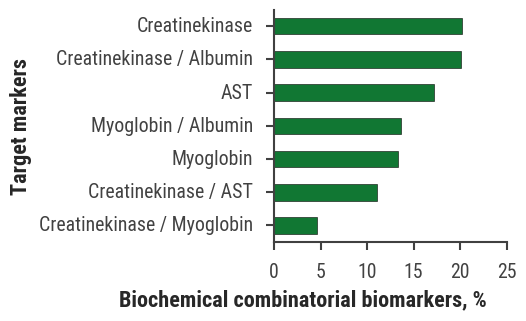

In [21]:
g = bio_df[['Target marker']].stack()\
                             .value_counts()\
                             .sort_values(ascending=True)\
                             .apply(lambda x: np.around(x / bio_df['Biomarker'].count() * 100, 1))\
                             .plot(kind='barh', figsize=(3,3), color='#117733')

g.set_ylabel('Target markers')
g.set_xlabel('Biochemical combinatorial biomarkers, %', ha='center', position=(0.125, 0))

sns.despine()

In [23]:
bio_df[['Target marker']].stack()\
                         .value_counts()\
                         .sort_values(ascending=False)\
                         .apply(lambda x: np.around(x / bio_df['Biomarker'].count() * 100, 1))\

Creatinekinase                20.2
Creatinekinase / Albumin      20.1
AST                           17.2
Myoglobin / Albumin           13.6
Myoglobin                     13.3
Creatinekinase / AST          11.1
Creatinekinase / Myoglobin     4.6
dtype: float64

### 1.4.2 Occurence of Individual Markers in Combinatorial Markers

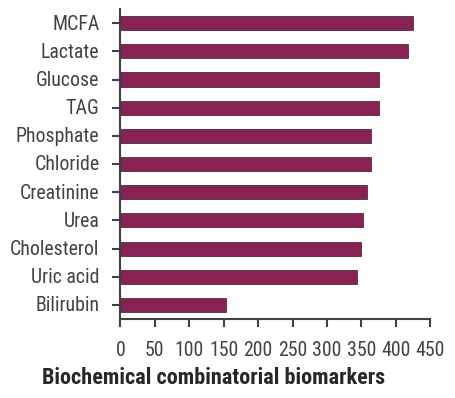

In [25]:
unique_markers = bio_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)

g = unique_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .sort_values(ascending=True)\
            .plot(kind='barh', figsize=(4,4), color='#882255')

g.set_xlabel('Biochemical combinatorial biomarkers', ha='center', position=(0.30, 0))
sns.despine()

In [48]:
# Percentage of single markers in combinatorial biomarkers
unique_markers = bio_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)
g = unique_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .apply(lambda x: str(np.around(x / unique_markers['MID'].count() * 100, 1)) + '%')\
            .sort_values(ascending=False)
g

MCFA           40.0%
Lactate        39.2%
Glucose        35.3%
TAG            35.3%
Phosphate      34.2%
Chloride       34.2%
Creatinine     33.7%
Urea           33.1%
Cholesterol    32.8%
Uric acid      32.4%
Bilirubin      14.4%
dtype: object

### 1.4.3 Biochemical biomarkers and target markers: joint sets

In [27]:
q = bio_df.groupby(('Biomarker'))\
          .agg({'Target marker': 'count', 'Kernel Ridge Score': 'mean', 'Theil-Sen Score': 'mean', 'Ridge Score': 'mean'})\
          .sort_values(['Target marker', 'Kernel Ridge Score'], ascending=False)

ipy.display(ipy.Markdown('#### Markers strongly correlated with three or more targets'),
            len(q[q['Target marker'] >= 3].index))

ipy.display(ipy.Markdown('#### Unique combinatorial markers'),
            len(q.index),
            ipy.HTML(
                        q.head(10)\
                          [['Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]
                          .reset_index()\
                          .to_html()
))

#### Markers strongly correlated with three or more targets

504

#### Unique combinatorial markers

1063

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score
0,1/MCFA,7,0.871264,0.307921,0.611971
1,TAG*Phosphate/Lactate/Uric acid,7,0.858034,0.424495,0.904730
2,Phosphate*Chloride/Lactate/Bilirubin,7,0.814122,0.275579,1.082766
3,Lactate*Bilirubin/Creatinine/Urea,7,0.756006,0.271455,1.609417
4,Urea*Chloride/Creatinine/Lactate,7,0.730320,0.324502,0.713174
5,Creatinine*Bilirubin/Lactate/MCFA,7,0.465168,0.126523,1.025088
6,Glucose*Uric acid/Cholesterol/MCFA,6,0.947046,0.169089,0.123946
7,Creatinine/Chloride/Glucose,6,0.936062,0.138021,0.944984
8,Cholesterol*Phosphate/Glucose,6,0.915915,0.237433,0.223080
9,Creatinine*Urea/Cholesterol/MCFA,6,0.900253,0.454116,0.912222


In [28]:
writer = pd.ExcelWriter('Results/combinatorial_biochemical_markers_top_10_joint.xlsx', engine='xlsxwriter')

j = bio_df.groupby(('Biomarker'))\
          .agg({'Target marker': 'count', 'Kernel Ridge Score': 'mean', 'Theil-Sen Score': 'mean', 'Ridge Score': 'mean'})\
          .sort_values(['Target marker', 'Kernel Ridge Score'], ascending=False)\
          .head(10)\
          [['Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]\
          .reset_index()
ipy.display(j)

j.to_excel(writer, sheet_name='Markers')
writer.save()

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score
0,1/MCFA,7,0.871264,0.307921,0.611971
1,TAG*Phosphate/Lactate/Uric acid,7,0.858034,0.424495,0.904730
2,Phosphate*Chloride/Lactate/Bilirubin,7,0.814122,0.275579,1.082766
3,Lactate*Bilirubin/Creatinine/Urea,7,0.756006,0.271455,1.609417
4,Urea*Chloride/Creatinine/Lactate,7,0.730320,0.324502,0.713174
5,Creatinine*Bilirubin/Lactate/MCFA,7,0.465168,0.126523,1.025088
6,Glucose*Uric acid/Cholesterol/MCFA,6,0.947046,0.169089,0.123946
7,Creatinine/Chloride/Glucose,6,0.936062,0.138021,0.944984
8,Cholesterol*Phosphate/Glucose,6,0.915915,0.237433,0.223080
9,Creatinine*Urea/Cholesterol/MCFA,6,0.900253,0.454116,0.912222


In [29]:
bio_df.groupby('Biomarker')[bio_df.columns]\
      .agg(['count', 'mean', 'std'])\
      .sort_values([('Theil-Sen Score', 'count')], ascending=False)

Theil-Sen Score                      \
                                                   count      mean       std   
Biomarker                                                                      
Lactate*Bilirubin/Creatinine/Urea                      7  1.609417  0.592825   
1/MCFA                                                 7  0.611971  0.236438   
Creatinine*Bilirubin/Lactate/MCFA                      7  1.025088  0.331368   
Urea*Chloride/Creatinine/Lactate                       7  0.713174  0.380744   
TAG*Phosphate/Lactate/Uric acid                        7  0.904730  0.480351   
Phosphate*Chloride/Lactate/Bilirubin                   7  1.082766  0.393192   
Phosphate*Chloride/Uric acid/MCFA                      6  0.818121  0.144124   
Phosphate*Uric acid/Cholesterol/TAG                    6  0.508818  0.245375   
Lactate*Bilirubin/Urea/Chloride                        6  2.056829  1.045101   
Lactate*Bilirubin/Urea/Glucose                         6  2.033353  0.953587   
Lactate*MCFA/Creatinine/Glucose                        6  0.803478  0.229451   
Chloride/Cholesterol/MCFA                              6  1.001768  0.350581   
Phosphate/Lactate/Bilirubin                            6  1.028870  0.304977   
Phosphate/Uric acid/MCFA                               6  0.801165  0.153188   
Lactate*Bilirubin/Cholesterol/Urea                     6  1.682848  0.588984   
TAG*Glucose/Lactate/MCFA                               6  1.395333  0.592852   
TAG*MCFA/Creatinine/Chloride                           6  0.373794  0.118212   
Urea*Chloride/Lactate/Bilirubin                        6  1.234849  0.184826   
Lactate*Bilirubin/Creatinine/Chloride                  6  1.607529  0.712459   
Glucose*Uric acid/Cholesterol/MCFA                     6  0.123946  0.149802   
Lactate*Bilirubin/Chloride/MCFA                        6  2.136819  1.356351   
Creatinine*Phosphate/Lactate/Bilirubin                 6  1.388944  0.354452   
Cholesterol*Uric acid/Lactate/MCFA                     6  1.138119  0.391202   
Creatinine*Chloride/Cholesterol/MCFA                   6  1.128871  0.534184   
Creatinine*Chloride/Lactate/Bilirubin                  6  1.085726  0.137029   
Creatinine*Cholesterol/Lactate/Bilirubin               6  0.914264  0.265822   
Creatinine*Phosphate/Cholesterol/Lactate               6  0.934511  0.279550   
Creatinine*Phosphate/Cholesterol/MCFA                  6  0.787169  0.222653   
Cholesterol*Phosphate/Glucose                          6  0.223080  0.186653   
Urea*Glucose/Lactate/Chloride                          6  0.951703  0.313595   
...                                                  ...       ...       ...   
Glucose/MCFA                                           1  0.352703       NaN   
Glucose/Phosphate/MCFA                                 1  0.445031       NaN   
Glucose/TAG/Chloride                                   1  0.668247       NaN   
Glucose/TAG/MCFA                                       1  0.275867       NaN   
TAG*Bilirubin/Cholesterol/Phosphate                    1  0.082631       NaN   
Glucose/Urea/Lactate                                   1  0.355394       NaN   
TAG*Chloride/Phosphate/Bilirubin                       1  0.060269       NaN   
TAG*Chloride/Urea/Bilirubin                            1  0.022768       NaN   
Creatinine/Urea/Lactate                                1  0.307403       NaN   
TAG*Chloride/Urea/Lactate                              1  0.348155       NaN   
TAG*MCFA/Cholesterol/Glucose                           1  0.205862       NaN   
Creatinine/Urea/MCFA                                   1  0.446165       NaN   
TAG*MCFA/Chloride/Glucose                              1  0.214657       NaN   
Glucose*MCFA/Creatinine/Chloride                       1  0.620358       NaN   
TAG*Glucose/Urea/Lactate                               1  0.303428       NaN   
Glucose*MCFA/Creatinine/Urea                           1  0.867770       NaN   
TAG*Glucose/Urea/Bilirubin               

## 1.4 Cross-Validation

In [30]:
def cv_iter(num):

    bio_cv_dict = {'Biomarker': [], 'Target marker': [], 'Type': [],
                   'MAPE': [], 'MAD': [], 'MSE': [], 'RMSE': []}

    for btn, i in itertools.product(bio_target_names, np.arange(num)):

        params = bio_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['MID']\
                   .split(', ')
        group = bio_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['Type']

        name = bio_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['Biomarker']

        target_data = bio_target_data[np.where(bio_target_names == btn)[0][0]]

        params = list(map(int, params))

        d = {}
        for i, (l, p) in enumerate(zip(st.ascii_letters[: len(params)], bio_data1h[[params]])):
            d[l] = p

        X = ne.evaluate(group, d)
        X = sk_pr.normalize(X.reshape(-1, 1), axis=0)

        ridge = sk_lm.Ridge(alpha=0.001, normalize=False)
        ridge.fit(X, target_data)

        kr = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001)
        kr.fit(X, target_data.reshape(-1, 1))

        # Cross-Validation
        MAPE_scores = np.array([])
        MAD_scores = np.array([])
        MSE_scores = np.array([])
        RMSE_scores = np.array([])

        kf = sk_cv.KFold(n_splits=10, random_state=9)

        for train_index, test_index in kf.split(X):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = target_data[train_index], target_data[test_index]

            kr_cv = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001).fit(X_train, y_train)
            y_pred = kr_cv.predict(X_test)

            MAPE = np.sum(np.abs((y_test - y_pred)) / y_test * 100) / 2
            MAD = np.sum(np.abs(y_test - y_pred)) / 2
            MSE = np.sum(np.abs(y_test - y_pred)**2) / 2
            RMSE = np.sqrt(MSE)

            MAPE_scores = np.append(MAPE_scores, MAPE)
            MAD_scores = np.append(MAD_scores, MAD)
            MSE_scores = np.append(MSE_scores, MSE)
            RMSE_scores = np.append(RMSE_scores, RMSE)

        bio_cv_dict['Biomarker'].append(name)
        bio_cv_dict['Target marker'].append(btn)
        bio_cv_dict['Type'].append(group)

        bio_cv_dict['MAPE'].append(MAPE_scores.mean())
        bio_cv_dict['MAD'].append(MAD_scores.mean())
        bio_cv_dict['MSE'].append(MSE_scores.mean())
        bio_cv_dict['RMSE'].append(RMSE_scores.mean())

    return bio_cv_dict

# initialize ExcelWriter
writer = pd.ExcelWriter('Results/combinatorial_biochemical_markers_cv_results.xlsx', engine='xlsxwriter')

# convert the dataframe to an XlsxWriter Excel object
df10 = cv_iter(10)
bio_cv_df_10 = pd.DataFrame(df10, index=np.arange(len(bio_target_names) * 10))
bio_cv_df_10.sort_values(by='MAPE').reset_index(drop=True).head(10).to_excel(writer, sheet_name='Overall')

# convert the dataframe to an XlsxWriter Excel object
bio_cv_df_1 = pd.DataFrame(cv_iter(1), index=np.arange(len(bio_target_names) * 1))
bio_cv_df_1.sort_values(by='MAPE').reset_index(drop=True).head(10).to_excel(writer, sheet_name='Top 1 by Target')

# save an Excel file
writer.save()

(10, 1)


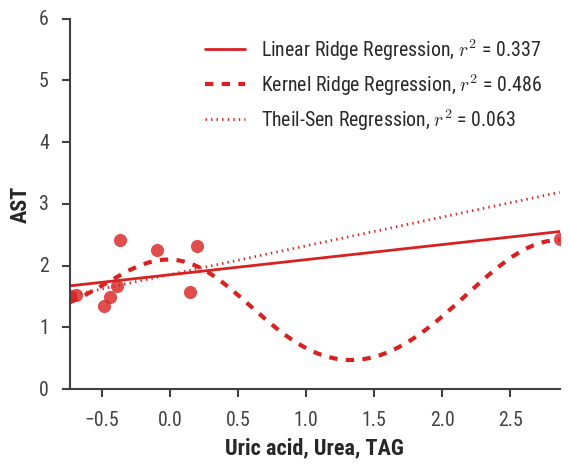

In [31]:
def visualize_marker(ms, tm, t):
    
    marker_type = t
    markers = ms
    target_marker_name = tm

    # Marker ids
    ids = [np.where(bio_parameter_names == n)[0][0] for n in markers]

    target_data = bio_target_data[np.where(bio_target_names == target_marker_name)[0][0]]

    d = {}
    for i, (l, p) in enumerate(zip(st.ascii_letters[: len(ids)], bio_data1h[[ids]])):
        d[l] = p

    X = ne.evaluate(marker_type, d)
    #
    #X = sk_pr.normalize(X.reshape(-1, 1), axis=0)
    #X = np.log10(X)
    X = ((X - np.mean(X)) / np.std(X)).reshape(-1, 1)

    ridge = sk_lm.Ridge(alpha=0.01, normalize=False)
    ridge.fit(X, target_data)

    kr = sk_kr.KernelRidge(kernel='rbf', alpha=0.01)
    kr.fit(X, target_data.reshape(-1, 1))

    ts = sk_lm.TheilSenRegressor()
    ts.fit(X, target_data)

    xmin = np.min(X)
    xmax = np.max(X)

    f = plt.figure(figsize=(6, 5))

    flatui = ["#D92120", "#E6642C", "#117733", "#4B91C0", "#781C81"]
    sns.set_palette(sns.color_palette(flatui))

    # Xs for plotting
    Xs = np.linspace(xmin, xmax, 200)[:, None]
    
    g = sns.regplot(x='a', y='b', data={'a': X, 'b': target_data}, color=flatui[0], fit_reg=False,
                    scatter_kws={'s': 90})
    print(target_data.reshape(-1, 1).shape)
    g.plot(Xs, ridge.predict(Xs),
            '-', label='Linear Ridge Regression, $r^2$ = %.3f' % ridge.score(X, target_data.reshape(-1, 1)),
            color=flatui[0], lw=2, zorder=1)

    g.plot(Xs, kr.predict(Xs),
            '--', label='Kernel Ridge Regression, $r^2$ = %.3f' % kr.score(X, target_data.reshape(-1, 1)),
            color=flatui[0], lw=3, zorder=1)

    g.plot(Xs, ts.predict(Xs),
            ':', label='Theil-Sen Regression, $r^2$ = %.3f' % ts.score(X, target_data.reshape(-1, 1)),
            color=flatui[0], lw=2, zorder=1)
    
    g.legend(loc='best')

    g.set(xlim=(xmin, xmax), ylim=(0, 6))

    g.set_xlabel(", ".join(markers), fontweight='bold')
    g.set_ylabel(target_marker_name, fontweight='bold')

    sns.despine()
    plt.tight_layout()

#visualize_marker(['Cholesterol', 'Phosphate', 'Chloride'], 'Creatinekinase / Albumin', 'a/b')
visualize_marker(['Uric acid', 'Urea', 'TAG'], 'AST', 'a/b/c')

# 2 Physiological markers

## 2.1 Importing Data

In [33]:
# read pickle to pandas DataFrame
phys_df = pd.read_pickle('phys_db.pickle')

# biomarkers
phys_df['Biomarker'].count()

7597

## 2.2 Importing and Preprocessing Raw Data

In [34]:
# Parameter names
phys_csv_names = csv.reader(open('./PhysData/parameters-names.csv'), delimiter=';')
phys_parameter_names = np.array(list(phys_csv_names)).ravel()

# Setting shape of data array
phys_volunteers = 10
phys_parameters = 15
phys_points = 8

# Initializing data array with zeros
phys_data = np.zeros(shape=(phys_volunteers, phys_parameters, phys_points))

# Timepoints at which each biochemical parameter was measured (in hours after experiment)
# 0 stands for "before experiment", 0.05 - shortly after experiment, 1 - in an hour after experiment, so on...
phys_timepoints = np.array([0, 0.05, 1, 1*24, 2*24, 3*24, 5*24, 7*24, 9*24])

# Reading numeric data from csv-files
# Each file has a shape of N x M
#     where N is the number of parameters and M is the number of timepoints at which they were measured
for i in np.arange(phys_volunteers):
    phys_csv_file = csv.reader(open('./PhysData/%d.csv' % i), delimiter=';')
    phys_data[i, 0: phys_parameters + 1, 0: phys_points + 1] = np.array(list(phys_csv_file), np.float64)

# Mask zeros with NaN
phys_data[phys_data == 0] = np.nan

# Making an array of 1-hour measures
phys_data1h = phys_data[:,:,2].T
imp = sk_pr.Imputer(missing_values='NaN', strategy='mean')
phys_data1h = imp.fit_transform(phys_data1h)

# Shape
np.shape(phys_data1h)

(15, 10)

## 2.3 Results

In [38]:
# Unique physiological biomarkers
phys_df['Biomarker'].unique().size

3185

### 2.3.1 Combinatorial Markers with Highest Scores

In [39]:
phys_df.sort_values(by='Kernel Ridge Score', ascending=False)\
      .head(10)\
      .reset_index(drop=True)\
      [['Biomarker', 'Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score
0,Max Amp EMG*EMG Freq/Relax Tone/Isometric Stre...,Myoglobin,0.997313,0.013204,0.598146
1,Max Amp EMG*EMG Freq/Relax Tone/Isometric Stre...,Myoglobin / Albumin,0.996510,0.009489,0.549831
2,H-r Amplitude*DIA Blood Pres 1/H-r Latency/R-T...,Creatinekinase / AST,0.995506,0.078827,0.186965
3,H-r Latency*DIA Blood Pres 2/L-Thigh Circ/Isom...,Creatinekinase / AST,0.994865,0.138781,0.365234
4,Max Amp EMG*EMG Freq/Relax Tone/Isometric Stre...,AST,0.993386,0.128575,0.462295
5,H-r Latency*SYS Blood Pres 2/Relax Tone/SYS Bl...,Creatinekinase,0.991216,0.116986,0.925131
6,L-Thigh Circ*SYS Blood Pres 1/R-Thigh Circ/SYS...,Creatinekinase / AST,0.990762,0.027852,0.274453
7,H-r Latency*SYS Blood Pres 2/Relax Tone/SYS Bl...,Creatinekinase / Albumin,0.990346,0.127056,0.873207
8,Contrac Tone/R-Thigh Circ/DIA Blood Pres 2,Creatinekinase / AST,0.990329,0.478630,0.290464
9,Relax Tone/Contrac Tone/DIA Blood Pres 1,AST,0.990140,0.012883,0.284468


### 2.3.2 Combinatorial Markers Grouped by Type

In [40]:
# Showing top 3 in each group
for i, g in enumerate(phys_df.groupby('Type').groups.keys()):
    ipy.display(ipy.Markdown('### Combinatorial biomarkers of type _' + g + '_'))
    ipy.display(phys_df.groupby('Type')\
                .get_group(g)\
                .sort_values(by='Kernel Ridge Score', ascending=False)\
                .head(3)\
                .reset_index(drop=True))

### Combinatorial biomarkers of type _a_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Isometric Strength,Creatinekinase / AST,Isometric Strength,NaN,NaN,NaN,0.268908,0.486873,0.876781,10,3,a
1,H-r Length,AST,H-r Length,NaN,NaN,NaN,0.524797,0.028542,0.850222,5,1,a
2,DIA Blood Pres 2,Myoglobin / Albumin,DIA Blood Pres 2,NaN,NaN,NaN,0.860721,0.023314,0.607033,14,6,a


### Combinatorial biomarkers of type _a/b/c_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Contrac Tone/R-Thigh Circ/DIA Blood Pres 2,Creatinekinase / AST,Contrac Tone,R-Thigh Circ,DIA Blood Pres 2,NaN,0.290464,0.478630,0.990329,"9, 6, 14",3,a/b/c
1,Relax Tone/Contrac Tone/DIA Blood Pres 1,AST,Relax Tone,Contrac Tone,DIA Blood Pres 1,NaN,0.284468,0.012883,0.990140,"8, 9, 12",1,a/b/c
2,Isometric Strength/H-r Latency/DIA Blood Pres 2,Creatinekinase / AST,Isometric Strength,H-r Latency,DIA Blood Pres 2,NaN,0.369583,0.048079,0.988883,"10, 3, 14",3,a/b/c


### Combinatorial biomarkers of type _a/b_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,H-r Length/L-Thigh Circ,AST,H-r Length,L-Thigh Circ,NaN,NaN,0.594480,0.047787,0.978674,"5, 7",1,a/b
1,Mean Amp EMG/Max Amp EMG,Creatinekinase / Myoglobin,Mean Amp EMG,Max Amp EMG,NaN,NaN,0.754267,0.087495,0.973293,"1, 0",4,a/b
2,Isometric Strength/H-r Latency,Creatinekinase / AST,Isometric Strength,H-r Latency,NaN,NaN,0.386056,0.171987,0.969316,"10, 3",3,a/b


### Combinatorial biomarkers of type _1/a_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,1/H-r Length,Creatinekinase / Albumin,H-r Length,NaN,NaN,NaN,0.890764,0.011874,0.888615,5,5,1/a
1,1/H-r Length,Creatinekinase,H-r Length,NaN,NaN,NaN,0.832747,0.012219,0.882356,5,0,1/a
2,1/H-r Length,AST,H-r Length,NaN,NaN,NaN,0.728332,0.005261,0.869566,5,1,1/a


### Combinatorial biomarkers of type _a*b/c_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,EMG Freq*L-Thigh Circ/Isometric Strength,AST,EMG Freq,L-Thigh Circ,Isometric Strength,NaN,1.091863,0.000281,0.985529,"2, 7, 10",1,a*b/c
1,H-r Amplitude*Contrac Tone/SYS Blood Pres 2,Creatinekinase / AST,H-r Amplitude,Contrac Tone,SYS Blood Pres 2,NaN,0.248206,0.516288,0.982421,"4, 9, 13",3,a*b/c
2,R-Thigh Circ*L-Thigh Circ/Contrac Tone,AST,R-Thigh Circ,L-Thigh Circ,Contrac Tone,NaN,0.745364,0.381536,0.980683,"6, 7, 9",1,a*b/c


### Combinatorial biomarkers of type _a*b/c/d_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Max Amp EMG*EMG Freq/Relax Tone/Isometric Stre...,Myoglobin,Max Amp EMG,EMG Freq,Relax Tone,Isometric Strength,0.598146,0.013204,0.997313,"0, 2, 8, 10",2,a*b/c/d
1,Max Amp EMG*EMG Freq/Relax Tone/Isometric Stre...,Myoglobin / Albumin,Max Amp EMG,EMG Freq,Relax Tone,Isometric Strength,0.549831,0.009489,0.996510,"0, 2, 8, 10",6,a*b/c/d
2,H-r Amplitude*DIA Blood Pres 1/H-r Latency/R-T...,Creatinekinase / AST,H-r Amplitude,DIA Blood Pres 1,H-r Latency,R-Thigh Circ,0.186965,0.078827,0.995506,"4, 12, 3, 6",3,a*b/c/d


### 2.3.3 Combinatorial Markers Grouped by Target Markers

In [41]:
# Showing top 5 of each target marker
for i, g in enumerate(phys_df.groupby('Target marker').groups.keys()):
    ipy.display(ipy.Markdown('### Combinatorial biomarkers correlation with _' + g + '_'))
    ipy.display(phys_df.groupby('Target marker')\
                .get_group(g)\
                .sort_values(by='Kernel Ridge Score', ascending=False)\
                .head(5)\
                .reset_index(drop=True))

### Combinatorial biomarkers correlation with _AST_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Max Amp EMG*EMG Freq/Relax Tone/Isometric Stre...,AST,Max Amp EMG,EMG Freq,Relax Tone,Isometric Strength,0.462295,0.128575,0.993386,"0, 2, 8, 10",1,a*b/c/d
1,Relax Tone/Contrac Tone/DIA Blood Pres 1,AST,Relax Tone,Contrac Tone,DIA Blood Pres 1,NaN,0.284468,0.012883,0.990140,"8, 9, 12",1,a/b/c
2,L-Thigh Circ*Relax Tone/Max Amp EMG/H-r Amplitude,AST,L-Thigh Circ,Relax Tone,Max Amp EMG,H-r Amplitude,0.347976,0.163888,0.989751,"7, 8, 0, 4",1,a*b/c/d
3,H-r Length*SYS Blood Pres 1/H-r Latency/Isomet...,AST,H-r Length,SYS Blood Pres 1,H-r Latency,Isometric Strength,0.161125,0.297329,0.988172,"5, 11, 3, 10",1,a*b/c/d
4,H-r Amplitude*SYS Blood Pres 1/Contrac Tone/SY...,AST,H-r Amplitude,SYS Blood Pres 1,Contrac Tone,SYS Blood Pres 2,0.607109,0.169386,0.987805,"4, 11, 9, 13",1,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,H-r Latency*SYS Blood Pres 2/Relax Tone/SYS Bl...,Creatinekinase,H-r Latency,SYS Blood Pres 2,Relax Tone,SYS Blood Pres 1,0.925131,0.116986,0.991216,"3, 13, 8, 11",0,a*b/c/d
1,L-Thigh Circ*Relax Tone/H-r Length/Contrac Tone,Creatinekinase,L-Thigh Circ,Relax Tone,H-r Length,Contrac Tone,0.658710,0.053471,0.987176,"7, 8, 5, 9",0,a*b/c/d
2,R-Thigh Circ*Relax Tone/H-r Latency/DIA Blood ...,Creatinekinase,R-Thigh Circ,Relax Tone,H-r Latency,DIA Blood Pres 1,0.643429,0.317052,0.982255,"6, 8, 3, 12",0,a*b/c/d
3,L-Thigh Circ*Relax Tone/H-r Latency/DIA Blood ...,Creatinekinase,L-Thigh Circ,Relax Tone,H-r Latency,DIA Blood Pres 1,0.594602,0.234874,0.981088,"7, 8, 3, 12",0,a*b/c/d
4,Mean Amp EMG*Isometric Strength/Contrac Tone/D...,Creatinekinase,Mean Amp EMG,Isometric Strength,Contrac Tone,DIA Blood Pres 1,1.897145,0.343509,0.980591,"1, 10, 9, 12",0,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / AST_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,H-r Amplitude*DIA Blood Pres 1/H-r Latency/R-T...,Creatinekinase / AST,H-r Amplitude,DIA Blood Pres 1,H-r Latency,R-Thigh Circ,0.186965,0.078827,0.995506,"4, 12, 3, 6",3,a*b/c/d
1,H-r Latency*DIA Blood Pres 2/L-Thigh Circ/Isom...,Creatinekinase / AST,H-r Latency,DIA Blood Pres 2,L-Thigh Circ,Isometric Strength,0.365234,0.138781,0.994865,"3, 14, 7, 10",3,a*b/c/d
2,L-Thigh Circ*SYS Blood Pres 1/R-Thigh Circ/SYS...,Creatinekinase / AST,L-Thigh Circ,SYS Blood Pres 1,R-Thigh Circ,SYS Blood Pres 2,0.274453,0.027852,0.990762,"7, 11, 6, 13",3,a*b/c/d
3,Contrac Tone/R-Thigh Circ/DIA Blood Pres 2,Creatinekinase / AST,Contrac Tone,R-Thigh Circ,DIA Blood Pres 2,NaN,0.290464,0.478630,0.990329,"9, 6, 14",3,a/b/c
4,Contrac Tone*Isometric Strength/R-Thigh Circ/R...,Creatinekinase / AST,Contrac Tone,Isometric Strength,R-Thigh Circ,Relax Tone,0.314204,0.275112,0.989556,"9, 10, 6, 8",3,a*b/c/d


### Combinatorial biomarkers correlation with _Creatinekinase / Myoglobin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,H-r Length*Relax Tone/Contrac Tone/Isometric S...,Creatinekinase / Myoglobin,H-r Length,Relax Tone,Contrac Tone,Isometric Strength,0.004431,0.165455,0.985598,"5, 8, 9, 10",4,a*b/c/d
1,DIA Blood Pres 1*SYS Blood Pres 2/Contrac Tone...,Creatinekinase / Myoglobin,DIA Blood Pres 1,SYS Blood Pres 2,Contrac Tone,Isometric Strength,0.152260,0.064283,0.980856,"12, 13, 9, 10",4,a*b/c/d
2,Relax Tone*DIA Blood Pres 1/EMG Freq/H-r Length,Creatinekinase / Myoglobin,Relax Tone,DIA Blood Pres 1,EMG Freq,H-r Length,0.068868,0.003825,0.976800,"8, 12, 2, 5",4,a*b/c/d
3,H-r Latency*H-r Amplitude/SYS Blood Pres 1,Creatinekinase / Myoglobin,H-r Latency,H-r Amplitude,SYS Blood Pres 1,NaN,0.118822,0.016318,0.976183,"3, 4, 11",4,a*b/c
4,SYS Blood Pres 1/H-r Latency/H-r Amplitude,Creatinekinase / Myoglobin,SYS Blood Pres 1,H-r Latency,H-r Amplitude,NaN,0.161986,0.041912,0.973880,"11, 3, 4",4,a/b/c


### Combinatorial biomarkers correlation with _Creatinekinase / Albumin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,H-r Latency*SYS Blood Pres 2/Relax Tone/SYS Bl...,Creatinekinase / Albumin,H-r Latency,SYS Blood Pres 2,Relax Tone,SYS Blood Pres 1,0.873207,0.127056,0.990346,"3, 13, 8, 11",5,a*b/c/d
1,L-Thigh Circ*Relax Tone/H-r Length/Contrac Tone,Creatinekinase / Albumin,L-Thigh Circ,Relax Tone,H-r Length,Contrac Tone,0.645519,0.051226,0.984746,"7, 8, 5, 9",5,a*b/c/d
2,Relax Tone*SYS Blood Pres 1/H-r Latency/SYS Bl...,Creatinekinase / Albumin,Relax Tone,SYS Blood Pres 1,H-r Latency,SYS Blood Pres 2,0.854699,0.157280,0.981701,"8, 11, 3, 13",5,a*b/c/d
3,Isometric Strength*DIA Blood Pres 1/H-r Latenc...,Creatinekinase / Albumin,Isometric Strength,DIA Blood Pres 1,H-r Latency,SYS Blood Pres 2,1.202079,0.064711,0.980637,"10, 12, 3, 13",5,a*b/c/d
4,R-Thigh Circ*Relax Tone/H-r Latency/DIA Blood ...,Creatinekinase / Albumin,R-Thigh Circ,Relax Tone,H-r Latency,DIA Blood Pres 1,0.657104,0.324909,0.979912,"6, 8, 3, 12",5,a*b/c/d


### Combinatorial biomarkers correlation with _Myoglobin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Max Amp EMG*EMG Freq/Relax Tone/Isometric Stre...,Myoglobin,Max Amp EMG,EMG Freq,Relax Tone,Isometric Strength,0.598146,0.013204,0.997313,"0, 2, 8, 10",2,a*b/c/d
1,R-Thigh Circ*L-Thigh Circ/H-r Latency/Relax Tone,Myoglobin,R-Thigh Circ,L-Thigh Circ,H-r Latency,Relax Tone,1.027864,0.031622,0.985600,"6, 7, 3, 8",2,a*b/c/d
2,EMG Freq*L-Thigh Circ/H-r Latency/Isometric St...,Myoglobin,EMG Freq,L-Thigh Circ,H-r Latency,Isometric Strength,1.474919,0.058808,0.985453,"2, 7, 3, 10",2,a*b/c/d
3,DIA Blood Pres 1/R-Thigh Circ/SYS Blood Pres 2,Myoglobin,DIA Blood Pres 1,R-Thigh Circ,SYS Blood Pres 2,NaN,1.408356,0.622852,0.982858,"12, 6, 13",2,a/b/c
4,L-Thigh Circ/Contrac Tone/Isometric Strength,Myoglobin,L-Thigh Circ,Contrac Tone,Isometric Strength,NaN,0.217027,0.050341,0.982365,"7, 9, 10",2,a/b/c


### Combinatorial biomarkers correlation with _Myoglobin / Albumin_

,Biomarker,Target marker,Marker 1,Marker 2,Marker 3,Marker 4,Theil-Sen Score,Ridge Score,Kernel Ridge Score,MID,TID,Type
0,Max Amp EMG*EMG Freq/Relax Tone/Isometric Stre...,Myoglobin / Albumin,Max Amp EMG,EMG Freq,Relax Tone,Isometric Strength,0.549831,0.009489,0.996510,"0, 2, 8, 10",6,a*b/c/d
1,EMG Freq*L-Thigh Circ/H-r Latency/Isometric St...,Myoglobin / Albumin,EMG Freq,L-Thigh Circ,H-r Latency,Isometric Strength,1.826075,0.059891,0.987550,"2, 7, 3, 10",6,a*b/c/d
2,R-Thigh Circ*L-Thigh Circ/H-r Latency/Relax Tone,Myoglobin / Albumin,R-Thigh Circ,L-Thigh Circ,H-r Latency,Relax Tone,0.995356,0.029883,0.982195,"6, 7, 3, 8",6,a*b/c/d
3,H-r Latency*H-r Length/R-Thigh Circ/L-Thigh Circ,Myoglobin / Albumin,H-r Latency,H-r Length,R-Thigh Circ,L-Thigh Circ,0.958246,0.000057,0.981788,"3, 5, 6, 7",6,a*b/c/d
4,Mean Amp EMG*Isometric Strength/Contrac Tone/S...,Myoglobin / Albumin,Mean Amp EMG,Isometric Strength,Contrac Tone,SYS Blood Pres 1,0.967422,0.097956,0.981401,"1, 10, 9, 11",6,a*b/c/d


## 2.4 Statistics

### 2.4.1 Correlations Between Combinatorial Markers and Target Markers

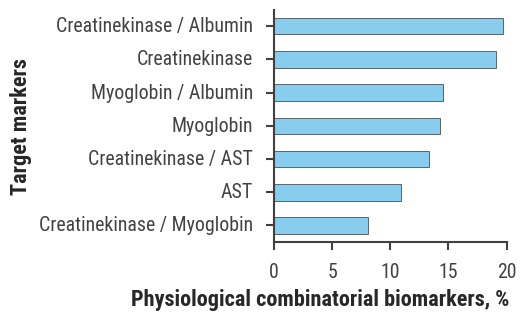

In [42]:
g = phys_df[['Target marker']].stack()\
                              .value_counts()\
                              .sort_values(ascending=True)\
                              .apply(lambda x: np.around(x / len(phys_df.index) * 100, 1))\
                              .plot(kind='barh', figsize=(3,3), color='#88CCEE')

g.set_ylabel('Target markers')
g.set_xlabel('Physiological combinatorial biomarkers, %', ha='center', position=(0.20, 0))

sns.despine()

In [43]:
phys_df[['Target marker']].stack()\
                          .value_counts()\
                          .sort_values(ascending=False)\
                          .apply(lambda x: np.around(x / len(phys_df.index) * 100, 1))

Creatinekinase / Albumin      19.7
Creatinekinase                19.1
Myoglobin / Albumin           14.5
Myoglobin                     14.3
Creatinekinase / AST          13.3
AST                           10.9
Creatinekinase / Myoglobin     8.1
dtype: float64

### 2.4.2 Occurence of Individual Markers in Combinatorial Markers

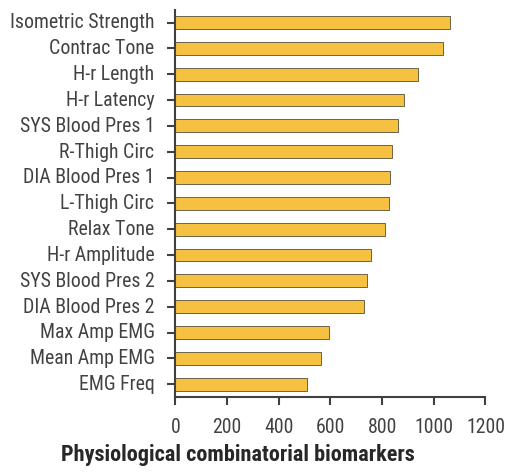

In [50]:
unique_markers = phys_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)

g = unique_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .sort_values(ascending=True)\
            .plot(kind='barh', figsize=(4, 5), color='#F6C141')

g.set_xlabel('Physiological combinatorial biomarkers', ha='center', position=(0.20, 0))

sns.despine()

In [52]:
unique_markers = phys_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)

g = unique_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .apply(lambda x: str(np.around(x / len(unique_markers.index) * 100, 1)) + '%')
g

Isometric Strength    33.4%
Contrac Tone          32.5%
H-r Length            29.5%
H-r Latency           27.8%
SYS Blood Pres 1      27.0%
R-Thigh Circ          26.3%
DIA Blood Pres 1      26.0%
L-Thigh Circ          26.0%
Relax Tone            25.5%
H-r Amplitude         23.7%
SYS Blood Pres 2      23.3%
DIA Blood Pres 2      22.9%
Max Amp EMG           18.6%
Mean Amp EMG          17.7%
EMG Freq              15.9%
dtype: object

### 1.4.3 Physiological biomarkers and target markers: joint sets

In [53]:
q = phys_df.groupby(('Biomarker'))\
      .agg({'Target marker': 'count', 'Kernel Ridge Score': 'mean', 'Theil-Sen Score': 'mean', 'Ridge Score': 'mean'})\
      .sort_values(['Target marker', 'Kernel Ridge Score'], ascending=False)

ipy.display(ipy.Markdown('#### Markers strongly correlated with three or more targets'),
            len(q[q['Target marker'] >= 3].index))

ipy.display(ipy.Markdown('#### Unique combinatorial markers'),
            len(q.index),
            ipy.HTML(
                        q.head(10)\
                          [['Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]
                          .reset_index()\
                          .to_html()
))

#### Markers strongly correlated with three or more targets

1054

#### Unique combinatorial markers

3185

,Biomarker,Target marker,Kernel Ridge Score,Ridge Score,Theil-Sen Score
0,R-Thigh Circ*DIA Blood Pres 1/H-r Latency/H-r ...,7,0.945168,0.028579,0.164029
1,L-Thigh Circ*Isometric Strength/Contrac Tone/D...,7,0.924334,0.316239,0.553227
2,Relax Tone/Contrac Tone/DIA Blood Pres 1,7,0.918476,0.024037,0.314835
3,H-r Length*Contrac Tone/Relax Tone/SYS Blood P...,7,0.916335,0.036826,0.545868
4,H-r Latency*H-r Amplitude/H-r Length,7,0.914053,0.036425,0.695606
5,Relax Tone*SYS Blood Pres 1/H-r Length/Contrac...,7,0.909458,0.025194,0.720275
6,L-Thigh Circ*DIA Blood Pres 1/H-r Length/DIA B...,7,0.909076,0.025418,0.761615
7,R-Thigh Circ*DIA Blood Pres 2/L-Thigh Circ/Rel...,7,0.905975,0.076496,0.489226
8,H-r Latency*H-r Length/R-Thigh Circ/DIA Blood ...,7,0.903848,0.022907,0.159196
9,R-Thigh Circ/Mean Amp EMG/H-r Length,7,0.899948,0.052640,0.144435


#### Export to Excel

In [54]:
writer = pd.ExcelWriter('Results/combinatorial_physiological_markers_top_10_joint.xlsx', engine='xlsxwriter')

phys_df.groupby(('Biomarker'))\
      .agg({'Target marker': 'count', 'Kernel Ridge Score': 'mean', 'Theil-Sen Score': 'mean', 'Ridge Score': 'mean'})\
      .sort_values(['Target marker', 'Kernel Ridge Score'], ascending=False)\
      .head(10)\
      [['Target marker', 'Kernel Ridge Score', 'Ridge Score', 'Theil-Sen Score']]\
      .reset_index()\
      .to_excel(writer, sheet_name='Markers')


writer.save()

## 2.5 Cross-Validation

In [55]:
def cv_iter(num):

    phys_cv_dict = {'Biomarker': [], 'Target marker': [], 'Type': [],
                   'MAPE': [], 'MAD': [], 'MSE': [], 'RMSE': []}

    for btn, i in itertools.product(bio_target_names, np.arange(num)):

        params = phys_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['MID']\
                   .split(', ')
        group = phys_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['Type']

        name = phys_df.groupby('Target marker')\
                   .get_group(btn)\
                   .sort_values(by='Kernel Ridge Score', ascending=False)\
                   .reset_index(drop=True)\
                   .loc[i]['Biomarker']

        target_data = bio_target_data[np.where(bio_target_names == btn)[0][0]]

        params = list(map(int, params))

        d = {}
        for i, (l, p) in enumerate(zip(st.ascii_letters[: len(params)], phys_data1h[[params]])):
            d[l] = p

        X = ne.evaluate(group, d)
        X = sk_pr.normalize(X.reshape(-1, 1), axis=0)

        ridge = sk_lm.Ridge(alpha=0.001, normalize=False)
        ridge.fit(X, target_data)

        kr = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001)
        kr.fit(X, target_data.reshape(-1, 1))

        # Cross-Validation
        MAPE_scores = np.array([])
        MAD_scores = np.array([])
        MSE_scores = np.array([])
        RMSE_scores = np.array([])

        kf = sk_cv.KFold(n_splits=10, random_state=9)

        for train_index, test_index in kf.split(X):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = target_data[train_index], target_data[test_index]

            kr_cv = sk_kr.KernelRidge(kernel='rbf', alpha=0.0001).fit(X_train, y_train)
            y_pred = kr_cv.predict(X_test)

            MAPE = np.sum(np.abs((y_test - y_pred)) / y_test * 100) / 2
            MAD = np.sum(np.abs(y_test - y_pred)) / 2
            MSE = np.sum(np.abs(y_test - y_pred)**2) / 2
            RMSE = np.sqrt(MSE)

            MAPE_scores = np.append(MAPE_scores, MAPE)
            MAD_scores = np.append(MAD_scores, MAD)
            MSE_scores = np.append(MSE_scores, MSE)
            RMSE_scores = np.append(RMSE_scores, RMSE)

        phys_cv_dict['Biomarker'].append(name)
        phys_cv_dict['Target marker'].append(btn)
        phys_cv_dict['Type'].append(group)

        phys_cv_dict['MAPE'].append(MAPE_scores.mean())
        phys_cv_dict['MAD'].append(MAD_scores.mean())
        phys_cv_dict['MSE'].append(MSE_scores.mean())
        phys_cv_dict['RMSE'].append(RMSE_scores.mean())

    return phys_cv_dict

# initialize ExcelWriter
writer = pd.ExcelWriter('Results/combinatorial_physiological_markers_cv_results.xlsx', engine='xlsxwriter')

# convert the dataframe to an XlsxWriter Excel object
df10 = cv_iter(10)
phys_cv_df_10 = pd.DataFrame(df10, index=np.arange(len(bio_target_names) * 10))
phys_cv_df_10.sort_values(by='MAPE').reset_index(drop=True).head(10).to_excel(writer, sheet_name='Overall')

# convert the dataframe to an XlsxWriter Excel object
phys_cv_df_1 = pd.DataFrame(cv_iter(1), index=np.arange(len(bio_target_names) * 1))
phys_cv_df_1.sort_values(by='MAPE').reset_index(drop=True).head(10).to_excel(writer, sheet_name='Top 1 by Target')

# save an Excel file
writer.save()

# 3 Publication Figures

## Figure 3

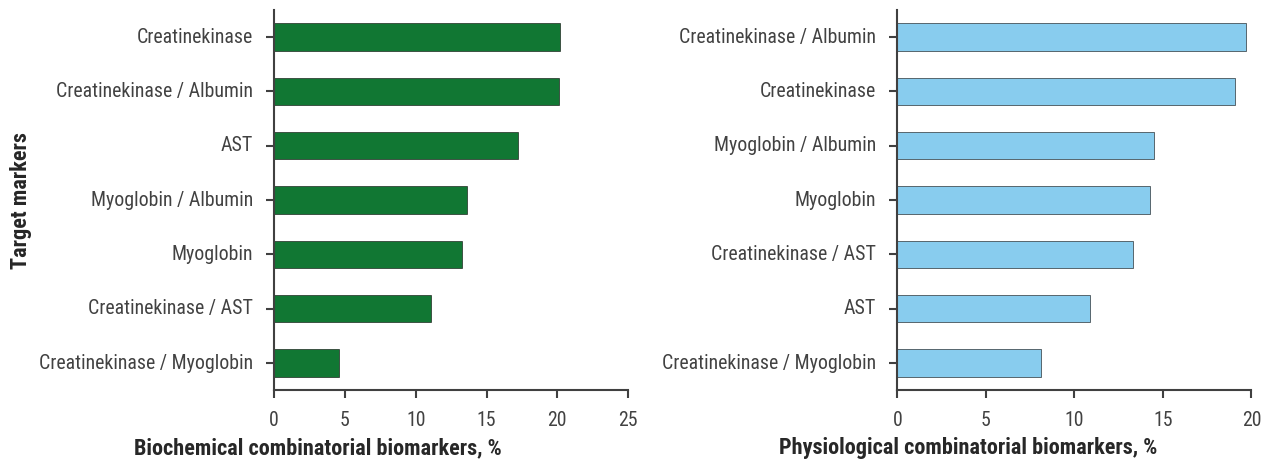

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False)
f.set_figheight(5)
f.set_figwidth(13)

g = bio_df[['Target marker']].stack()\
                             .value_counts()\
                             .sort_values(ascending=True)\
                             .apply(lambda x: np.around(x / bio_df['Biomarker'].count() * 100, 1))\
                             .plot(kind='barh', ax=ax1, color='#117733')

g.set_ylabel('Target markers')
g.set_xlabel('Biochemical combinatorial biomarkers, %', ha='center', position=(0.125, 0))

g2 = phys_df[['Target marker']].stack()\
                             .value_counts()\
                             .sort_values(ascending=True)\
                             .apply(lambda x: np.around(x / len(phys_df.index) * 100, 1))\
                             .plot(kind='barh', ax=ax2, color='#88CCEE')

g2.set_ylabel('')
g2.set_xlabel('Physiological combinatorial biomarkers, %', ha='center', position=(0.20, 0))
sns.despine()
f.tight_layout()
f.savefig('Results/figure 3.eps', format="eps")

## Figure 4

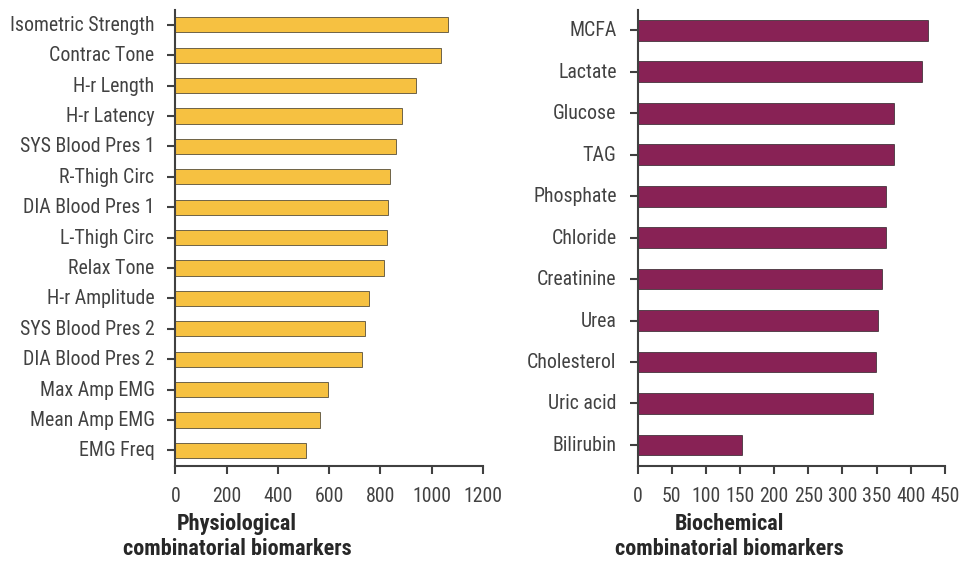

In [58]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False)
f.set_figheight(6)
f.set_figwidth(10)

# Physiological
unique_phys_markers = phys_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)
g = unique_phys_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .sort_values(ascending=True)\
            .plot(kind='barh', ax=ax1, color='#F6C141')
g.set_xlabel('Physiological\ncombinatorial biomarkers', ha='center', position=(0.20, 0))

# Biochemical
unique_biochem_markers = bio_df.drop_duplicates(subset='Biomarker').reset_index(drop=True)
g2 = unique_biochem_markers[['Marker 1', 'Marker 2', 'Marker 3', 'Marker 4']]\
            .stack()\
            .value_counts()\
            .sort_values(ascending=True)\
            .plot(kind='barh', ax=ax2, color='#882255')

g2.set_xlabel('Biochemical\ncombinatorial biomarkers', ha='center', position=(0.30, 0))

# Figure saving
sns.despine()
f.tight_layout()
f.savefig('Results/figure 4.eps', format="eps")